In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from xgcm import Grid

import cmocean as cm
import cartopy.crs as ccrs
import xarray

import cartopy.feature as cft
import matplotlib.path as mpath

In [2]:
pancontrol = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33031,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33611,Total threads: 1
Dashboard: /proxy/37577/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:33985,


In [4]:
#Time variant variables
data_SO = pancontrol.search(variable="so", frequency="1mon").to_dask()

In [5]:
#Time invariant variables
data_fixed = pancontrol.search(variable=["geolon","geolat"], path=".*output021.*").to_dask()

In [6]:
variables = pancontrol.unique().variable
print(variables)

['xT', 'xTe', 'yT', 'yTe', 'time', 'nv', 'siconc', 'sithick', 'average_T1', 'average_T2', 'average_DT', 'time_bnds', 'xh', 'yh', 'xq', 'yq', 'zos', 'tob', 'sob', 'mlotst', 'umo_2d', 'vmo_2d', 'tauuo', 'tauvo', 'hfds', 'wfo', 'fsitherm', 'salt_flux', 'salt_flux_added', 'rho2_l', 'rho2_i', 'volcello', 'umo', 'vmo', 'z_l', 'z_i', 'uo', 'vo', 'thetao', 'so', 'rhopot2', 'rhopot0', 'agessc', 'areacello', 'deptho', 'Coriolis', 'geolon', 'geolat', 'geolon_c', 'geolat_c', 'geolon_u', 'geolat_u', 'geolon_v', 'geolat_v', 'wet', 'wet_c', 'wet_u', 'wet_v', 'dxt', 'dyt', 'dxCu', 'dyCu', 'dxCv', 'dyCv', 'areacello_cu', 'areacello_cv', 'areacello_bu', 'net_melt', 'xB', 'yB', 'IX_TRANS', 'IY_TRANS', 'zl', 'T_adx_2d', 'T_ady_2d', 'z_l_sub01', 'precip', 'lrunoff', 'Kd_interface', 'T_adx', 'T_ady', 'Kd_heat', 'Kd_salt', 'Kd_ePBL', 'Kd_shear', 'Kd_BBL', 'dudt', 'dvdt', 'CAu', 'CAv', 'rvxv', 'rvxu', 'gKEu', 'gKEv', 'PFu', 'PFv', 'u_BT_accel', 'v_BT_accel', 'diffu', 'diffv', 'du_dt_visc', 'dv_dt_visc', 'taux

In [7]:
#Trying to define geolon and geolat to use instead of xh and yh. 

#GET THIS CHECKED

geolon = data_fixed.geolon
geolat = data_fixed.geolat
data_SO = data_SO.assign_coords({"geolon": geolon, "geolat": geolat})

In [8]:
SO_Tin_top = data_SO.so.isel(time=0,z_l=0)
SO_Tin_mid = data_SO.so.isel(time=0).sel(z_l='500', method='nearest')
SO_Tmean_top = data_SO.so.sel(time=slice('1991-01','1996-01')).mean(dim='time').isel(z_l=0)
SO_Tmean_mid = data_SO.so.sel(time=slice('1991-01','1996-01')).mean(dim='time').sel(z_l='500', method='nearest')
SO_Tmean_bot = data_SO.so.sel(time=slice('1991-01','1996-01')).mean(dim='time').sel(z_l='5.71e03',method='nearest')
#Note - should weight spatial means using area data 

In [9]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)

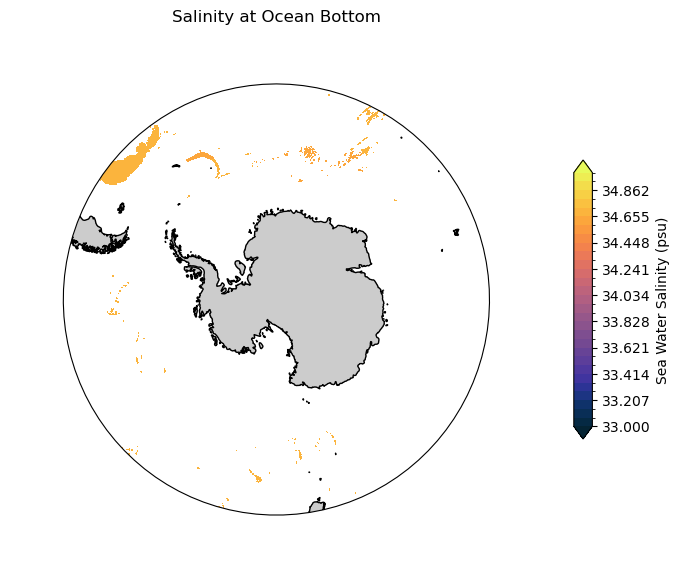

In [19]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SO_Tmean_bot.plot.contourf(
    x="geolon",
    y="geolat",
    levels=30,
    transform=ccrs.PlateCarree(),
    vmin=33,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity at Ocean Bottom");

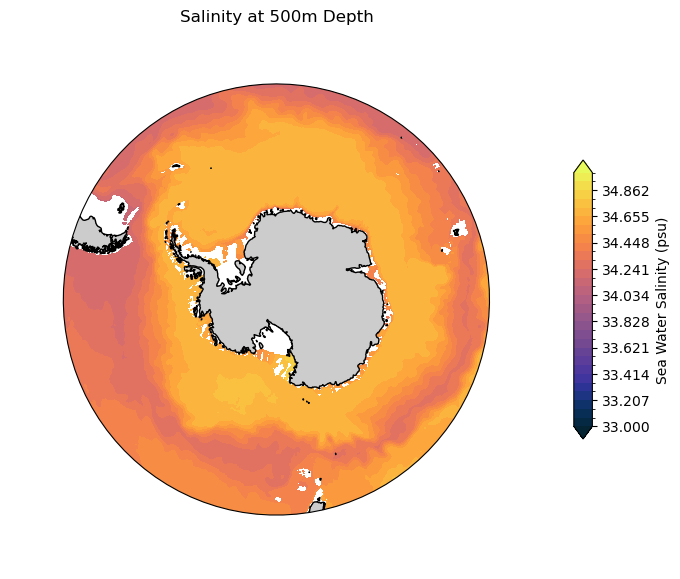

In [17]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SO_Tmean_mid.plot.contourf(
    x="geolon",
    y="geolat",
    transform=ccrs.PlateCarree(),
    levels=30,
    vmin=33,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity at 500m Depth");

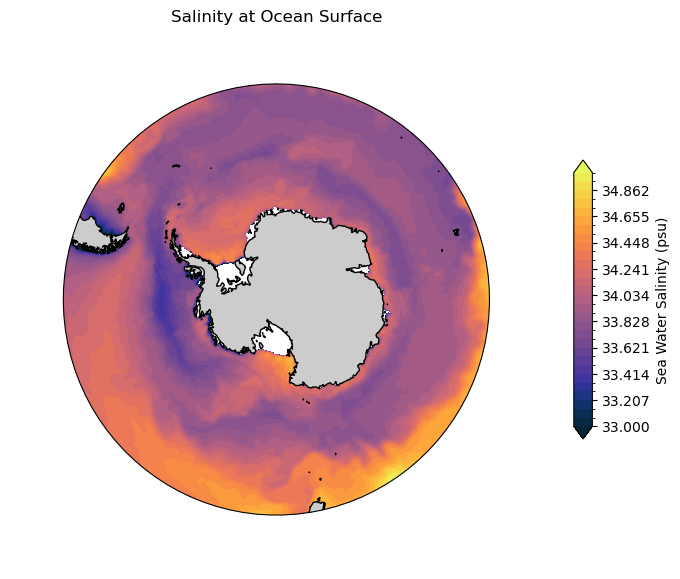

In [15]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SO_Tmean_top.plot.contourf(
    x="geolon",
    y="geolat",
    levels=30,
    transform=ccrs.PlateCarree(),
    vmin=33,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity at Ocean Surface");

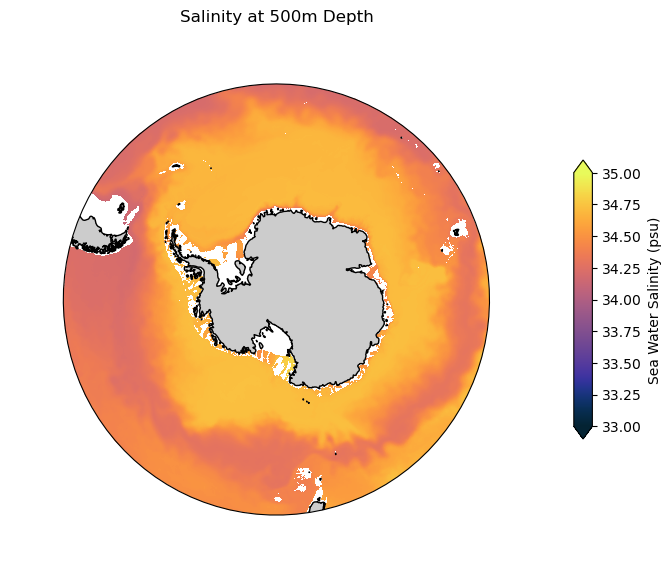

In [18]:
#Using xh and yh, for sake of example

projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SO_Tmean_mid.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=33,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Salinity at 500m Depth");

In [ ]:
#Getting land contours to match the model

#experiment = "025deg_jra55_iaf_omip2_cycle6"  # or, e.g., '1deg_jra55_iaf_omip2_cycle6' or '01deg_jra55v140_iaf_cycle3'

#var_search = catalog[experiment].search(variable="ht")
#ds = var_search.search(path=var_search.df.path[0]).to_dask()
#bathymetry = ds["ht"].load()

#land = xr.where(np.isnan(bathymetry.rename("land")), 1, np.nan)
#land = land.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})